# Data platform - lab nr. 1

## 1. Loading the data

- Pandas will be imported to provide necessary functionality in the form of dataframes and more
- Relevant file will be loaded using the read_csv function which is then converted to a dataframes object 

In [20]:
import pandas as pd

dataframe = pd.read_csv('lab_1.csv', sep=';')

dataframe.head()

,id,name,price,currency,created_at
0,SKU-1001,shoes,799,SEK,2024-01-10
1,SKU-1002,pants,520,SEK,2024/02/15
2,SKU-1003,shirts,450,SEK,NaN
3,NaN,jacket,-200,SEK,2024-13-01
4,SKU-1005,NaN,NaN,NaN,


## 2. Data cleaning

- From an overview of the data, certain values may benefit from standardization
- Excessive blank spaces may be removed without corrupting the data using .strip()
- Values may be 'checked' using to_numeric and to_datetime whereas impossible values will be nullified using errors='coerce'
- Note: changing the data excessively to satisfy our own idea of how it should look like can be dangerous

In [ ]:
dataframe['price'] = dataframe['price'].str.replace('free', '0', regex=False) # Can 'free' mean something else in this case?
dataframe['price'] = pd.to_numeric(dataframe['price'], errors='coerce')

dataframe['created_at'] = dataframe['created_at'].str.replace('/', '-', regex=False)
dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors='coerce')

dataframe['name'] = dataframe['name'].str.strip()

dataframe['currency'] = dataframe['currency'].str.strip()

dataframe.head()

,id,name,price,currency,created_at
0,SKU-1001,shoes,799.0,SEK,2024-01-10
1,SKU-1002,pants,520.0,SEK,2024-02-15
2,SKU-1003,shirts,450.0,SEK,NaT
3,NaN,jacket,-200.0,SEK,NaT
4,SKU-1005,NaN,NaN,NaN,NaT


## 3. Data rejection

- Since product identification has been deemed important, I have rejected missing values of the column 'id'

- Infering from the overall task, 'price' seems to be a priority since further analysis of it has been requested
    - Null values of 'price' has been removed
    - Negative values of 'price' has been removed
    - Very high values of 'price' or 'free' products have NOT been removed as they are technically valid (they will be flagged)
- The raw data will not be changed, instead new CSV-files will be created with rejected and accepted rows, separately 

- Concurrently, this will satisfy one of the bonus tasks since the cell will generate a file with the rejects

In [22]:
reject_condition = (
       (dataframe['id'].isna()) |
       (dataframe['price'].isna()) |
       (dataframe['price'] < 0)
)

df_rejected = dataframe[reject_condition].copy()
df_valid = dataframe[~reject_condition].copy()

df_rejected.to_csv('rejected_products.csv',sep=',', index=False)
df_valid.to_csv('accepted_products.csv', sep=',', index=False)

# 4. Flagging data

- Even if a row has been deemed good enough not to be rejected, missing values or 'extreme' prices may be flagged
- Note: I decided to flag the data AFTER data rejection to avoid the conundrum of flagging impossible values

In [23]:
df_valid = pd.read_csv('accepted_products.csv', sep=',')

df_valid['is_flagged'] = (
    (df_valid['name'].isna()) |
    (df_valid['currency'].isna()) |
    (df_valid['created_at'].isna()) |
    (df_valid['price'] == 0) |
    (df_valid['price'] > 10000)
)

df_valid.to_csv('flagged_products.csv', sep=',', index=False)

# 5. Analytics summary

- A CSV-file with some data regarding price and product frequency has been requested

- As a general rule, the source of the data comes from the validated products
    - Frequency of prices that are missing, since they were rejected, are sourced from the listed rejects

In [24]:
data = {
    'price_average': [df_valid['price'].mean().round()],
    'price_median': [df_valid['price'].median()],
    'products_frequency': [len(df_valid)],
    'missing_price': [df_rejected['price'].isnull().sum()]
}

analytics_summary = pd.DataFrame(data)

analytics_summary.to_csv('analytics_summary.csv',sep=',', index=False)
read_analytics_summary = pd.read_csv('analytics_summary.csv', sep=',')

read_analytics_summary

,price_average,price_median,products_frequency,missing_price
0,22487.0,560.0,48,4


# 6. Price analysis

- Statistics on the most deviant prices have been requested
- In regards to method; using z-scores may not work since the average is distorted by extreme outliers (see graph below) 

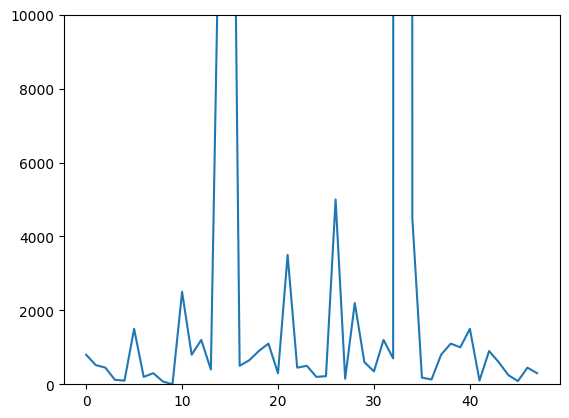

In [25]:
import matplotlib.pyplot as plt

df = pd.read_csv('accepted_products.csv', sep=',')
plt.plot(range(len(df['price'])), df["price"])
plt.ylim(0, 10000)
plt.show()

- The median, however, is not affected by extreme outliers

In [26]:
df_valid['deviant_price'] = (df_valid['price'] - df_valid['price'].median()).abs()

price_analysis = df_valid.sort_values(by='deviant_price', ascending=False)
price_analysis = (price_analysis.head(10))
price_analysis = pd.DataFrame(price_analysis)
price_analysis.to_csv('price_analysis.csv', sep=',', index=False)

read_price_analysis = pd.read_csv('price_analysis.csv', sep=',')
read_price_analysis

,id,name,price,currency,created_at,is_flagged,deviant_price
0,SKU-1039,coat,999999.0,SEK,2024-10-15,True,999439.0
1,SKU-1021,ring,25000.0,SEK,2024-06-05,True,24440.0
2,SKU-1020,watch,15000.0,SEK,2024-06-01,True,14440.0
3,SKU-1032,suit,5000.0,SEK,2024-09-01,False,4440.0
4,SKU-1040,parka,4500.0,SEK,2024-11-01,False,3940.0
5,SKU-1027,winter jacket,3500.0,SEK,2024-07-15,False,2940.0
6,SKU-1016,coat,2500.0,SEK,2024-05-01,False,1940.0
7,SKU-1034,blazer,2200.0,SEK,2024-09-10,False,1640.0
8,SKU-1047,heels,1500.0,SEK,2024-12-15,False,940.0
9,SKU-1010,boots,1500.0,SEK,2024-02-15,False,940.0
